In [1]:
!git clone https://github.com/sud0x00/SharadaScripture-OCR.git

Cloning into 'SharadaScripture-OCR'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 34 (delta 9), reused 27 (delta 5), pack-reused 0
Unpacking objects: 100% (34/34), 3.34 MiB | 3.57 MiB/s, done.


# Imports

In [45]:
import cv2
import numpy as np
import scipy.ndimage as rt
from matplotlib import pyplot as plt
import shutil
import os
import string
import random

# Pre-requisites

In [46]:

if os.path.exists('Line_Segment'):
    shutil.rmtree('Line_Segment')
if os.path.exists('Char_Segment'):
    shutil.rmtree('Char_Segment')

In [47]:
img_global = "/content/SharadaScripture-OCR/test/inclined_3.jpg"
img = cv2.imread(img_global)

# Skew Correction

In [48]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = rt.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

In [49]:
angle, corrected = correct_skew(img)
print(angle)

-4


# Line Segmentation

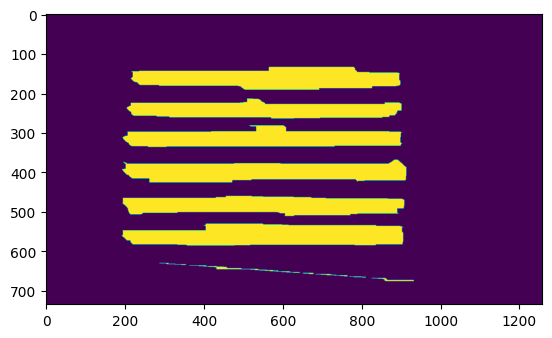

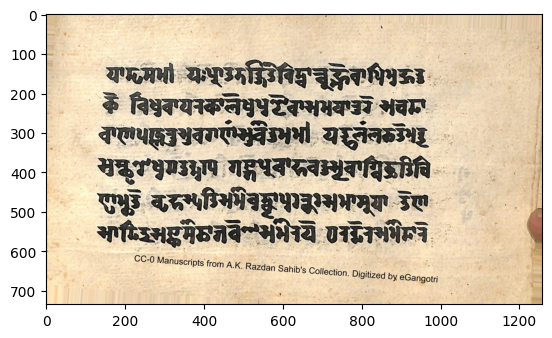

In [50]:
img = corrected

dnc = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)

# Convert the image to grayscale
gray = cv2.cvtColor(dnc, cv2.COLOR_BGR2GRAY)

ret, img_bin = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU) # imgf contains Binary image

# Defining a kernel length
kernel_len = np.array(img).shape[1]//50

# Defining a horizontal kernel for horizontal dilation
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 2))

# Use horizontal kernel to connect text characters and remove spaces
horizontal_lines = cv2.dilate(img_bin, hor_kernel, iterations=5)

# Now we erode
horizontal_lines = cv2.erode(horizontal_lines, hor_kernel, iterations=10)

plt.imshow(horizontal_lines)
plt.show()

# Find contours for image, which will detect all lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Calculate mean contour area
mean_area = np.mean([cv2.contourArea(ctr) for ctr in contours])

if os.path.exists('Line_Segment'):
    shutil.rmtree('Line_Segment')

# Create the "Line_Segment" folder if it doesn't exist
if not os.path.exists("Line_Segment"):
    os.makedirs("Line_Segment")

# Initialize a counter for naming the images
counter = 0

# Sort contours based on y-coordinate
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

# Define the NMS threshold value
nms_threshold = 0.5

# Convert the boxes list to a numpy array
boxes = np.array([cv2.boundingRect(contour) for contour in contours])

# Confidence scores (all set to 1)
scores = np.ones(len([cv2.boundingRect(contour) for contour in contours]))

# Apply NMS to get the indices of the selected bounding boxes
indices = cv2.dnn.NMSBoxes(boxes, scores, 0, nms_threshold)

# Filter the contours based on the NMS results
filtered_contours = [contours[i] for i in indices.flatten()]

# Initialize a counter for naming the line segments
counter = 0

#Random string used to make file names distinct
random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=15))

# Modify these values according to your requirements
expand_left = 1
expand_right = 1

# Loop over the contours
for contour in filtered_contours:
    # Skip small contours
    if cv2.contourArea(contour) < mean_area / (np.array(img).shape[1]//100):
        continue

    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)

    # Expand the bounding box if non-zero pixels are found
    while np.any(img_bin[y:y+h, x-expand_left:x] > 0):
        x -= expand_left
        w += expand_left
    while np.any(img_bin[y:y+h, x+w:x+w+expand_right] > 0):
        w += expand_right


    # Extract the content of the bounding box
    line_segment = img[y-10:y+h+10, x-10:x+w+10]


    # Generate a unique filename for the line segment
    filename = f"line_{counter}_{random_string}.jpg"

    # Save the line segment image
    cv2.imwrite(os.path.join("Line_Segment", filename), line_segment)

    # Draw the bounding box
    cv2.rectangle(img, (x-10, y-20), (x + w+10, y + h+20), (0, 255, 0), 2)

    # Increment the counter
    counter += 1
# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Char Segmentation

         Pre-Req

In [ ]:
# Character Segmentation
char_segment_dir = "Char_Segment"
if os.path.exists(char_segment_dir):
    shutil.rmtree(char_segment_dir)
os.makedirs(char_segment_dir)

In [ ]:
loc = "Line_Segment/line_4_qKBkh7gMxVQVs7c.jpg"
line_img = cv2.imread(loc)

In [ ]:
dnc_1 = cv2.fastNlMeansDenoisingColored(line_img, None, 10, 10, 75, 15)

gauss = cv2.GaussianBlur(dnc_1, (7,7), 0)
img_gray = cv2.cvtColor(gauss, cv2.COLOR_BGR2GRAY)
img_bin = cv2.threshold(img_gray)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'threshold'
> Overload resolution failed:
>  - threshold() missing required argument 'thresh' (pos 2)
>  - threshold() missing required argument 'thresh' (pos 2)


In [ ]:


cv2.imshow("mask",img_bin)
cv2.waitKey(0)



-1

In [ ]:
dnc_1 = cv2.fastNlMeansDenoisingColored(line_img, None, 10, 10, 5, 5)

ret, imgf = cv2.threshold(img_gray, 125, 255,cv2.THRESH_BINARY_INV,cv2.THRESH_OTSU) #imgf contains Binary image

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,8))
mask = cv2.morphologyEx(imgf, cv2.MORPH_DILATE , kernel)


## Convert the line image to grayscale
#gray = cv2.cvtColor(dnc_1, cv2.COLOR_BGR2GRAY)
#
## Apply adaptive thresholding to obtain a binary image
#img_bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

In [ ]:
# Defining a kernel length
kernel_len_ver = np.array(img).shape[0]//100
kernel_len_hor = np.array(img).shape[1]//100

# Defining a vertical kernel for vertical dilation
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_hor,1))


# Use horizontal kernel to connect text characters and remove spaces
vertical_lines = cv2.dilate(mask, ver_kernel, iterations=5)

vertical_lines = cv2.erode(vertical_lines, hor_kernel, iterations=1)


In [ ]:
cv2.imshow("line",vertical_lines)
cv2.waitKey(0)

-1

In [ ]:
# Find contours in the image
contours, _ = cv2.findContours(vertical_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from left to right
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

# Draw bounding boxes around characters
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(line_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green rectangles

# Display the result
cv2.imshow("Character Bounding Boxes", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#noise removal
nkernel = np.ones((1,10),np.uint8)
opening = cv2.morphologyEx(vertical_lines,cv2.MORPH_OPEN,nkernel, iterations = 5)

In [ ]:
cv2.imshow("line",opening)
cv2.waitKey(0)

-1